<center>
<img src="https://i.ibb.co/ZVRt2f7/logo.png" alt="logo" border="0" width=800>


---
## 03. First Convolutional Image Classification Neural Network


Eduard Larrañaga (ealarranaga@unal.edu.co)

---

### Abstract

In this notebook we will train a first convolutional neural network to classify galaxy images acording to their morphology. 

---

---

## The Galaxy10 SDSS Dataset

The Galaxy10 SDSS dataset contains 21785 colored images (g, r and i band) of galaxies with a size of 69x69 pixels separated in 10 classes:

- Class 0 (3461 images): Disk, Face-on, No Spiral
- Class 1 (6997 images): Smooth, Completely round
- Class 2 (6292 images): Smooth, in-between round
- Class 3 (394 images): Smooth, Cigar shaped
- Class 4 (1534 images): Disk, Edge-on, Rounded Bulge
- Class 5 (17 images): Disk, Edge-on, Boxy Bulge
- Class 6 (589 images): Disk, Edge-on, No Bulge
- Class 7 (1121 images): Disk, Face-on, Tight Spiral
- Class 8 (906 images): Disk, Face-on, Medium Spiral
- Class 9 (519 images): Disk, Face-on, Loose Spiral

These images come from the [Sloan Digital Sky Survey (SDSS)](http://www.sdss.org/) and the labels come from [Galaxy Zoo](https://www.zooniverse.org/projects/zookeeper/galaxy-zoo/).

This dataset can be downloaded from [here](https://astronn.readthedocs.io/en/latest/galaxy10sdss.html) or directly from [here](http://astro.utoronto.ca/~bovy/Galaxy10/Galaxy10.h5)

### Reading the dataset

The dataset is given in a .h5 file. Therefore, we will use the library `h5py`to read it,


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from sklearn.model_selection import train_test_split

# Read and separate the images and labels from the file
with h5py.File('/content/drive/MyDrive/Colab Notebooks/Neural Networks/03. Convolutional NN/Galaxy10SDSS.h5', 'r') as F:
    images = np.array(F['images'])
    labels = np.array(F['ans'])
  
# Define the classes names
galaxyClass = ['Disk, Face-on, No Spiral',
               'Smooth, Completely round',
               'Smooth, in-between round',
               'Smooth, Cigar shaped',
               'Disk, Edge-on, Rounded Bulge',
               'Disk, Edge-on, Boxy Bulge',
               'Disk, Edge-on, No Bulge',
               'Disk, Face-on, Tight Spiral',
               'Disk, Face-on, Medium Spiral',
               'Disk, Face-on, Loose Spiral']


The shapes of the images file and labels files are

In [ ]:
print(images.shape)
print(labels.shape)

(21785, 69, 69, 3)
(21785,)


Lets visualize some of the images in composite color,

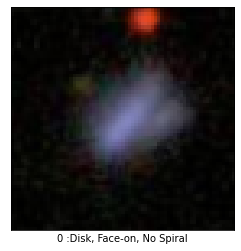

In [ ]:
i = int(np.random.rand(1)*21785)
plt.figure(figsize=(4,5))
plt.imshow(images[i])
plt.xticks([])
plt.yticks([])
plt.xlabel(f'{labels[i]:.0f} :'+ galaxyClass[labels[i]])
plt.show()

In order to classify the images, we will 'normalize' the images,

In [ ]:
# Normalize the input data
images = images.astype(np.float32)/255

Now we will split the dataset into training and test subsets

In [ ]:
train_idx, test_idx = train_test_split(np.arange(labels.shape[0]), test_size=0.1)
train_images, train_labels, test_images, test_labels = images[train_idx], labels[train_idx], images[test_idx], labels[test_idx]

## The Convolutional Classification Neural Network

We want to train a convolutional neural network model that reads the data and classify these images according to the morphology of the galaxt (targets). Therefore we need to declare the following:

- The model will be a 'Sequential' neural network.

- An input layer that reads the data in the image. This will be a  layer that takes the image of size 69 by 69 with 3 channels and will convert it into an array with 69x69x3 = 14283 entries. Therefore, we need 14283 neurons in this layer.

- Then, we will use a convolutional 2D layer with 32 kernels with a size of 3x3 pixels and a ReLU activation. The result is a set of 32 images of 69x69 pixel in each channel (i.e. a total of 3x32x69x69= 457046 numbers!!)

- In order to reduce the size of the data, we introduce a MaxPooling2D layer with size 2x2. This layer will use a 2x2 kernel which passes over each image and selects the brigthest  (maximum value) of the four pixels that is covering. As a result, each image will be reduced in size by a factor of 2. Hence, we will have a set of 32 images with 35x35 pixels and 3 channels (i.e. 3x32x35x35= 117600 numbers!!)

- After this we repat the same pair of layers (convolution and maxpooling) two times but using 64 kernels for the convolution.

- We also introduce a Dropout layer, which randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting. We use a rate of 0.5 (i.e. half of the neurons are randomly switched off)

- Then we use a dense layer with 128 neurons and a ReLU activation.

- Finally we will incorporate an output dense layer with 10 neurons (because the classes are given by a number from 0 to 9) and a 'softmax' activation function.



In [ ]:
import tensorflow as tf

model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(69, 69, 3)))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))

model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))

model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))

model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(10, activation=tf.nn.softmax))


In order to compile the neural network we will include the [ADAM](https://keras.io/api/optimizers/adam/) optimizer, the [SparseCategoricalCrossentropy](https://keras.io/api/losses/probabilistic_losses/#categoricalcrossentropy-class) loss function and the [accuracy](https://keras.io/api/metrics/accuracy_metrics/#accuracy-class) metric.

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
# print model summary before training
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 67, 67, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 33, 33, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 31, 31, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 15, 15, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 13, 13, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 6, 6, 64)         0

Now we will train the model using the train-sets and 5 epochs.

In [ ]:
history = model.fit(train_images, train_labels, epochs=5)

Epoch 1/5
613/613 [==============================] - 132s 213ms/step - loss: 1.3345 - accuracy: 0.4565
Epoch 2/5
613/613 [==============================] - 124s 203ms/step - loss: 0.9935 - accuracy: 0.6251
Epoch 3/5
613/613 [==============================] - 126s 205ms/step - loss: 0.8187 - accuracy: 0.6991
Epoch 4/5
613/613 [==============================] - 125s 204ms/step - loss: 0.7335 - accuracy: 0.7307
Epoch 5/5
613/613 [==============================] - 123s 200ms/step - loss: 0.6746 - accuracy: 0.7527


---
## Testing the Model

Now we will use the test subsets to probe the model. Using the '.evaluate()' method, we obtain the accuracy of the model (using the metric defined above),

In [ ]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

69/69 - 4s - loss: 0.6137 - accuracy: 0.7733 - 4s/epoch - 52ms/step

Test accuracy: 0.7732905149459839


Note that the trained model have an accuracy of  0.773 on the test set.

Using the '.predict()' method we will obtain the predictions for the test set,

In [ ]:
predictions = model.predict(test_images)

---
## Visualization of the Results

In order to visualize the result of the mode, we define two plotting functions. The first one shows the image together with the predicted value. The second one shows the probabilities of all the targets for the given sample.

In [ ]:
def plot_image(i, p=predictions, tar = test_labels, image = test_images):
  target, img = tar[i], image[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(img, cmap='gray')

  pred_target = np.argmax(p[i])
  if pred_target == target:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("Predicted: {} ({:2.0f}%)   True:{}".format(pred_target,
                                100*np.max(p),
                                target),
                                color=color)
  print("Prediction:",galaxyClass[pred_target])
  print("Label: ",galaxyClass[target])

def plot_value_array(i, p=predictions, tar = test_labels):
  target = tar[i]
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), p[i], color="#777777")
  plt.ylim([0, 1])
  pred_target = np.argmax(p[i])

  thisplot[pred_target].set_color('red')
  thisplot[target].set_color('blue')

Prediction: Disk, Face-on, No Spiral
Label:  Disk, Face-on, No Spiral


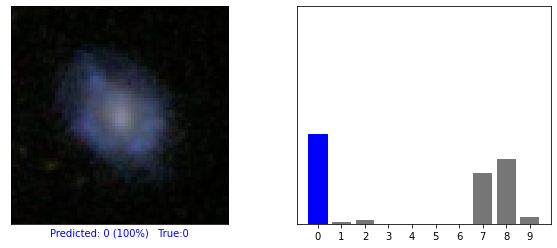

In [ ]:
i = int(np.random.rand(1)*len(test_labels))

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plot_image(i)
plt.subplot(1,2,2)
plot_value_array(i)
plt.show()
